## TODO
- relative entropy per gene per tissue?
- map GC grp to our isoform names
- search literature for other ways people have quantified isoform expression differences

In [29]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../../data/internal/GTEx-protein-gencode/protein.GC30-basic.txt',
                 sep='\t')
metadata = pd.read_csv('../../data/internal/GTEx-protein-gencode/SRA-filtered.txt',
                       sep='\t')
if metadata['UID'].duplicated().any():
    raise UserWarning('Unexpected duplicates')
metadata = metadata.set_index('UID')
if df.columns.duplicated().any():
    raise UserWarning('Unexpected duplicates')
if df['UID'].duplicated().any():
    raise UserWarning('Unexpected duplicates')
df = df.set_index('UID')

In [7]:
genes = pd.Series(index=df.index,
                  data=df.index.str.extract('GC grp\: ([A-Z0-9orf]{2,10})-.*', expand=False).values)

In [25]:
#genes = pd.read_csv('../../data/internal/GTEx-protein-gencode/a_gencode30_uniq_prot_and_annot_sachi_gloria_lambert.tsv',
#                    sep='\t')
#genes = (genes.loc[:, ['same_prot_seq_name', 'orig_gene']]
#              .drop_duplicates()
#              .set_index('same_prot_seq_name')['orig_gene'])

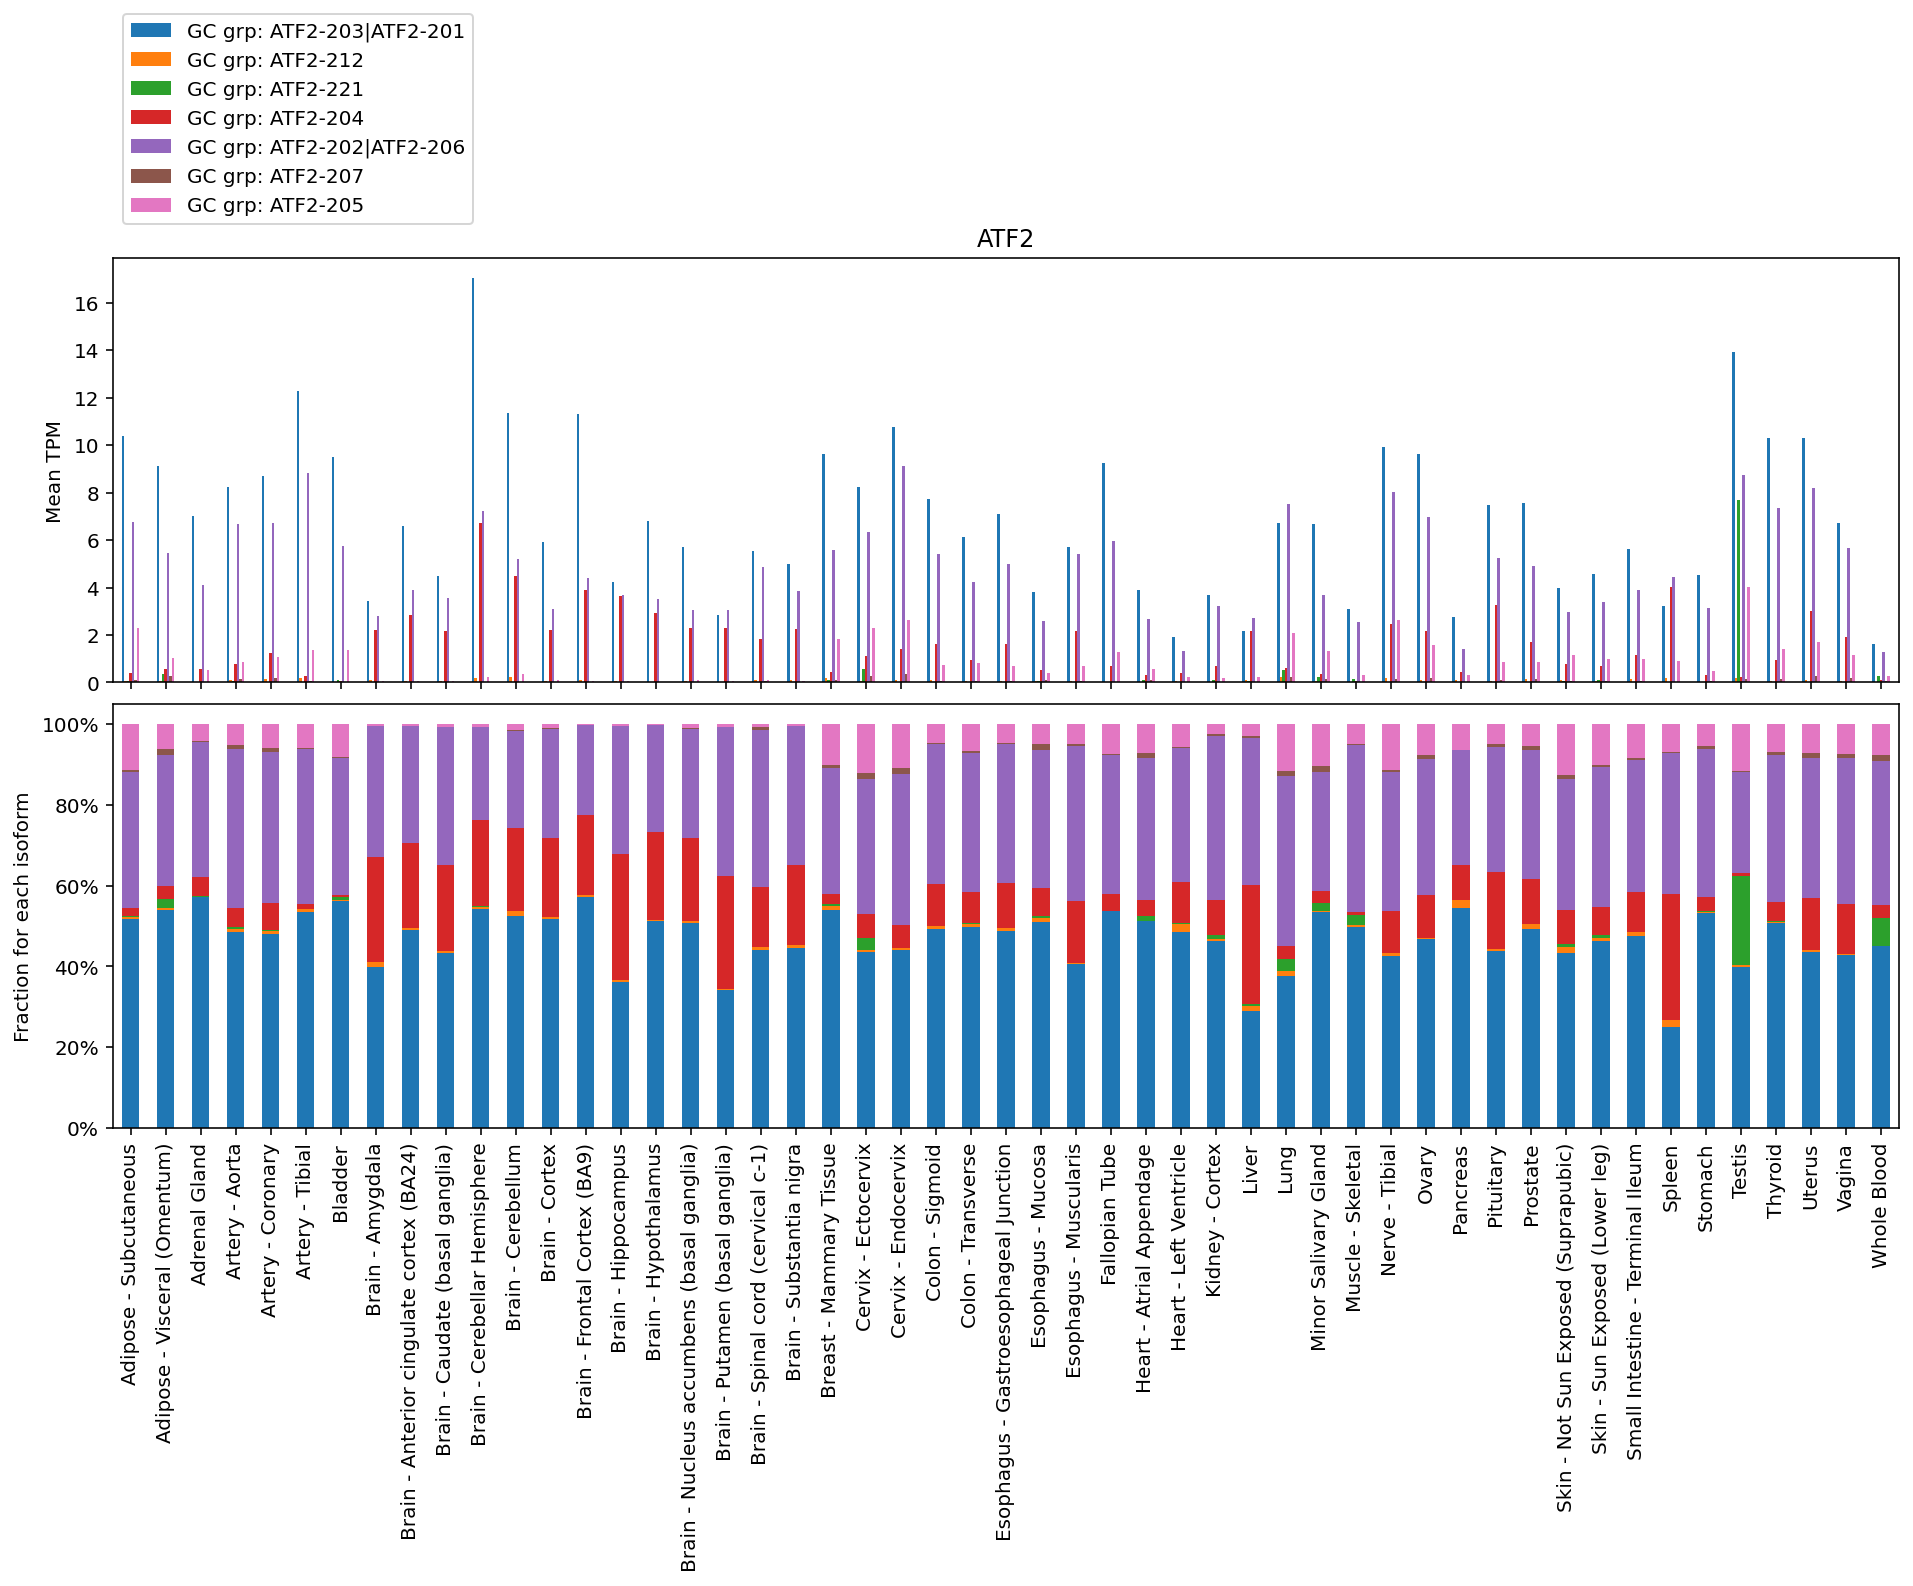

In [263]:
# add ratios
#gene_name = 'KCNIP3'
#gene_name = 'TFDP2'
'CREM' # lots of isoforms
'ELF5'  # Zero counts
'SPIB'  # Zero counts
#gene_name = 'FOXP1'  # example from slides
gene_name = 'LHX3'  # interesting because all isoforms in one tissue
gene_name = 'ATF2'

def per_tf_gene_tissue_expression_plot(gene_name, draw_legend=True):
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(16, 8)
    (means.loc[genes == gene_name, :]
          .T
          .plot.bar(ax=axes[0], legend=False))
    if draw_legend:
        axes[0].legend(loc='upper left', bbox_to_anchor=[0, 1.6])
    (means.loc[genes == gene_name, :]
          .div(means.loc[genes == gene_name, :].sum(axis=0))
          .T.plot.bar(ax=axes[1], 
                      stacked=True,
                      legend=False))
    axes[0].set_ylabel('Mean TPM')
    axes[0].set_title(gene_name)
    axes[1].set_ylabel('Fraction for each isoform')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    plt.subplots_adjust(hspace=0.05)
    
per_tf_gene_tissue_expression_plot(gene_name)

In [122]:
means = df.groupby(df.columns.map(metadata['body_site']), axis=1).mean()
medians = df.groupby(df.columns.map(metadata['body_site']), axis=1).median()
tip_score = (means.sub(means.median(axis=1), axis=0)
                    .div(means.quantile(q=0.75, axis=1) -
                         means.quantile(q=0.25, axis=1), axis=0))
f_i = means.div(means.sum(axis=1), axis=0)
q_i = 1. / f_i.shape[1]  # this is relative entropy
entropy_per_isoform = (f_i.mul((f_i / q_i).apply(np.log2))).sum(axis=1)

In [123]:
# gene-level tissue-speceficity metrics
gene_means = df.groupby(genes).sum().groupby(df.columns.map(metadata['body_site']), axis=1).mean()
gene_medians = df.groupby(genes).sum().groupby(df.columns.map(metadata['body_site']), axis=1).mean()
gene_tip = (gene_means.sub(gene_means.median(axis=1), axis=0)
                    .div(gene_means.quantile(q=0.75, axis=1) -
                         gene_means.quantile(q=0.25, axis=1), axis=0))
f_i = gene_means.div(gene_means.sum(axis=1), axis=0)
q_i = 1. / f_i.shape[1]  # this is relative entropy
gene_entropy_per_isoform = (f_i.mul((f_i / q_i).apply(np.log2))).sum(axis=1)

In [150]:
means.head()

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
UID,,,,,,,,,,,,,,,,,,,,,
GC grp: KCNIP3-201,0.320866,0.549520,0.193952,1.748496,0.911614,0.416810,1.152020,15.187042,21.835784,10.928037,...,1.109117,1.289281,0.617693,0.319070,0.687588,1.508054,15.245864,1.328414,1.988634,0.006746
GC grp: KCNIP3-202,4.277062,3.839456,0.913102,4.058979,5.678413,6.121371,7.884028,1.483555,1.950348,0.280481,...,3.139113,4.847568,2.902413,2.136687,2.731366,13.987272,8.625827,10.508315,8.203027,0.017152
GC grp: KCNIP3-205,1.112394,0.907475,0.250542,1.169372,1.486986,1.585320,2.733049,0.138504,0.152934,0.145206,...,0.761039,1.144991,0.704735,0.314373,0.687465,2.691088,2.745039,2.266222,2.017998,0.001631
GC grp: TFDP2-209,0.001616,0.022465,0.001029,0.030547,0.104351,0.062025,0.000000,0.013787,0.012486,0.004854,...,0.030708,0.000039,0.023237,0.007683,0.006546,0.017511,0.016865,0.000000,0.008577,0.032998
GC grp: NFATC2-206,0.123402,0.109483,0.005842,0.028423,0.028975,0.056912,0.074359,0.002326,0.002999,0.011687,...,0.021958,0.042319,0.049907,0.000553,0.013687,0.001590,0.011272,0.025156,0.034804,0.000000


In [124]:
iso = genes.to_frame(name='gene').copy()
iso['mean_TPM'] = means.mean(axis=1)
iso['median_TPM'] = medians.median(axis=1)
iso['max_TPM'] = means.max(axis=1)
iso['max_TiP_score'] = tip_score.max(axis=1)
iso['tissue_with_max_TiP_score'] = tip_score.idxmax(axis=1)
iso['entropy'] = entropy_per_isoform
iso['gene_max_TiP_score'] = iso['gene'].map(gene_tip.max(axis=1))
iso['gene_entropy'] = iso['gene'].map(gene_entropy_per_isoform)
iso.head()

,gene,mean_TPM,median_TPM,max_TPM,max_TiP_score,tissue_with_max_TiP_score,entropy,gene_max_TiP_score,gene_entropy
UID,,,,,,,,,
GC grp: KCNIP3-201,KCNIP3,4.730731,1.14878,34.159258,7.180937,Brain - Frontal Cortex (BA9),1.281457,3.739576,0.416541
GC grp: KCNIP3-202,KCNIP3,4.070982,2.11135,13.987272,1.925957,Testis,0.552172,3.739576,0.416541
GC grp: KCNIP3-205,KCNIP3,0.954930,0.53485,2.751074,1.573393,Cervix - Endocervix,0.613736,3.739576,0.416541
GC grp: TFDP2-209,TFDP2,0.026544,0.00000,0.192296,5.994056,Muscle - Skeletal,1.027768,11.933667,0.380116
GC grp: NFATC2-206,NFATC2,0.028196,0.00000,0.123402,2.509996,Adipose - Subcutaneous,0.825681,2.759350,0.331170


In [80]:
iso.loc[iso['max_TPM'] >= 5, :].sort_values('entropy', ascending=False)

,mean_TPM,median_TPM,max_TPM,max_TiP_score,tissue_with_max_TiP_score,entropy
UID,,,,,,
GC grp: LHX3-201,0.630867,0.000000,32.095247,inf,Brain - Cerebellum,5.640097
GC grp: LHX3-203,0.341561,0.000000,17.254277,inf,Pituitary,5.565158
GC grp: TGIF2LX-201|TGIF2LX-202,0.254343,0.000000,12.823528,inf,Testis,5.529604
GC grp: SPZ1-201,0.748803,0.000000,37.738520,inf,Bladder,5.518281
GC grp: DMRTB1-201,1.754300,0.000000,88.398521,2.425933e+04,Testis,5.517305
...,...,...,...,...,...,...
GC grp: USF2-207,5.457018,5.186700,11.922961,3.548409e+00,Spleen,0.065464
GC grp: ZNF24-201|ZNF24-202,12.117132,11.846565,19.190858,1.536740e+00,Nerve - Tibial,0.062517
GC grp: ZNF787-203,16.627450,16.644450,28.007114,1.698026e+00,Spleen,0.060316


In [45]:
means[means.index == 'GC grp: MECOM-209|MECOM-202']

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
UID,,,,,,,,,,,,,,,,,,,,,
GC grp: MECOM-209|MECOM-202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000599


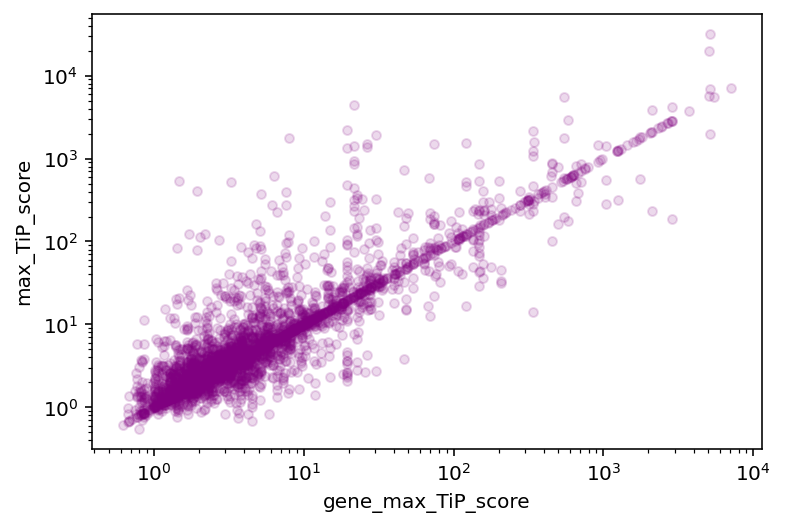

In [125]:
fig, ax = plt.subplots(1, 1)
(iso.loc[iso['max_TPM'] > 1, :]
    .plot.scatter(x='gene_max_TiP_score',
                  y='max_TiP_score',
                  alpha=0.15,
                  color='purple',
                  ax=ax))
ax.set_xscale('log')
ax.set_yscale('log')

In [ ]:
# theres a problem with infs in the TiP score
# a pseudo count wont help because it's in the IQR that's the problem 

In [129]:
# inspect inf values
(iso.loc[(iso['max_TPM'] > 1) & 
         (iso['max_TiP_score'] == np.inf), :]
    .sort_values('max_TiP_score', ascending=False).head(60))

,gene,mean_TPM,median_TPM,max_TPM,max_TiP_score,tissue_with_max_TiP_score,entropy,gene_max_TiP_score,gene_entropy
UID,,,,,,,,,
GC grp: ELF5-202,ELF5,0.054494,0.0,1.225020,inf,Adipose - Visceral (Omentum),3.304016,157.378821,2.847672
GC grp: SPIB-206,SPIB,0.070740,0.0,1.780027,inf,Adrenal Gland,4.079993,46.482740,1.790863


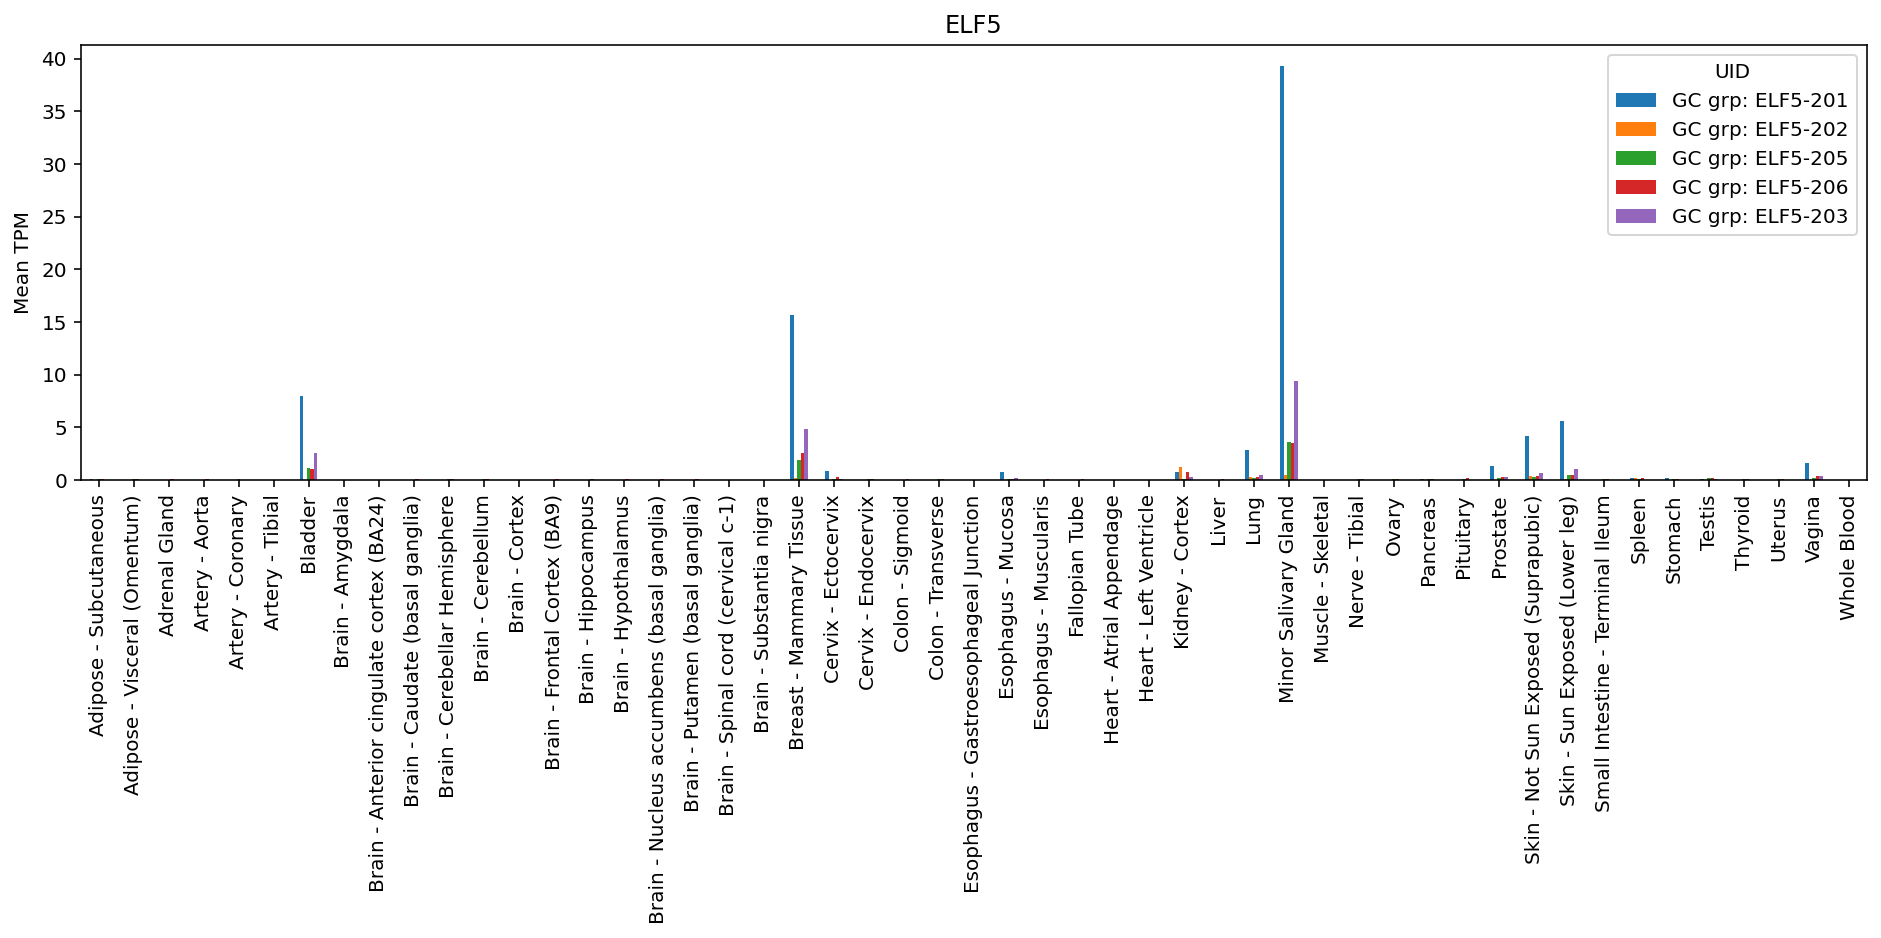

In [128]:
per_tf_gene_tissue_expression_plot('ELF5')

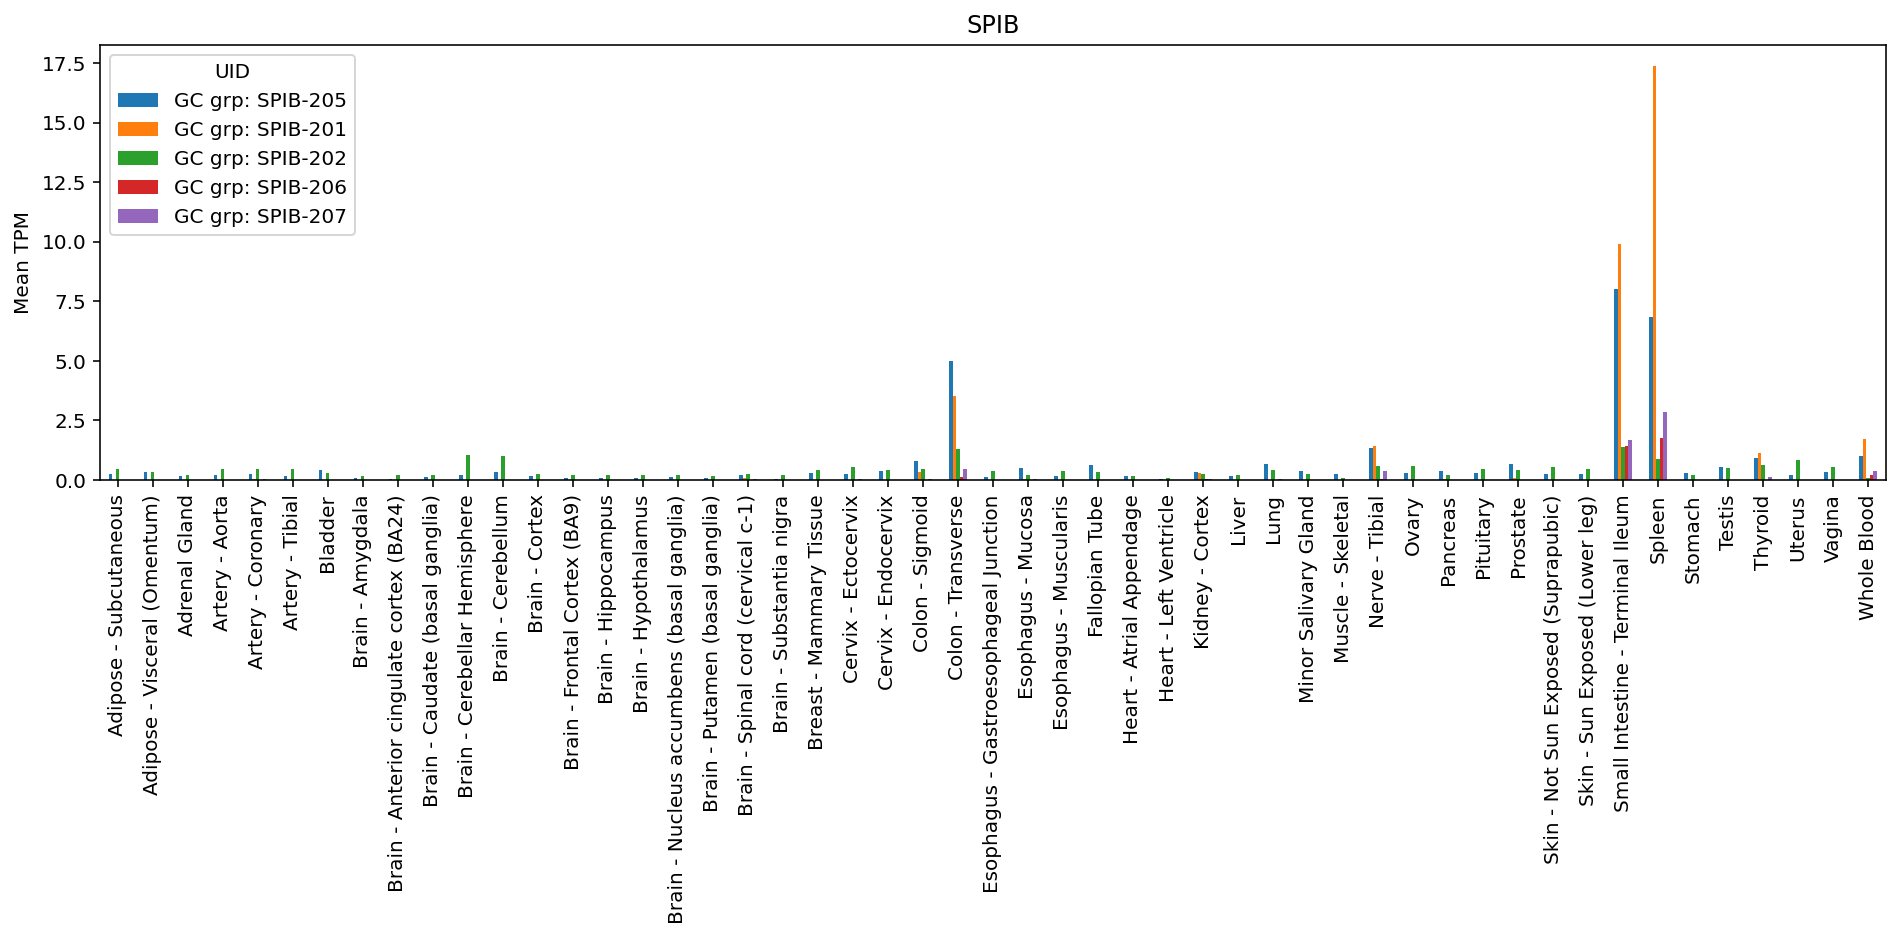

In [130]:
per_tf_gene_tissue_expression_plot('SPIB')

In [136]:
iso['TiP_diff'] = iso['max_TiP_score'] - iso['gene_max_TiP_score']
(iso.loc[(iso['max_TPM'] > 1), :]
    .sort_values('TiP_diff', ascending=False).head(20))

,gene,mean_TPM,median_TPM,max_TPM,max_TiP_score,tissue_with_max_TiP_score,entropy,gene_max_TiP_score,gene_entropy,TiP_diff
UID,,,,,,,,,,
GC grp: ELF5-202,ELF5,0.054494,0.000000,1.225020,inf,Adipose - Visceral (Omentum),3.304016,157.378821,2.847672,inf
GC grp: SPIB-206,SPIB,0.070740,0.000000,1.780027,inf,Adrenal Gland,4.079993,46.482740,1.790863,inf
GC grp: LHX3-201,LHX3,0.630867,0.000000,32.095247,3.214948e+04,Pituitary,5.640097,5132.668250,5.469344,2.701681e+04
GC grp: RBPJL-202,RBPJL,0.021123,0.000000,1.012338,1.974863e+04,Pancreas,5.173539,5074.792170,5.401619,1.467384e+04
GC grp: PAX2-205,PAX2,0.227335,0.000000,8.530218,5.541667e+03,Kidney - Cortex,4.340632,542.458194,3.779960,4.999208e+03
GC grp: NKX2-1-204|NKX2-1-203|NKX2-1-202,NKX2,6.087343,0.034760,223.506054,4.397460e+03,Thyroid,4.350722,21.634620,2.040385,4.375825e+03
GC grp: DMRTC2-201,DMRTC2,0.894524,0.000000,44.872292,2.952043e+03,Testis,5.474133,578.526758,4.716489,2.373516e+03
GC grp: CREM-214,CREM,0.918972,0.000000,46.178180,2.219029e+03,Testis,5.497497,19.384145,0.479916,2.199645e+03
GC grp: PGR-207,PGR,0.085541,0.000000,4.272300,1.939730e+03,Testis,5.445477,30.387226,1.954641,1.909343e+03


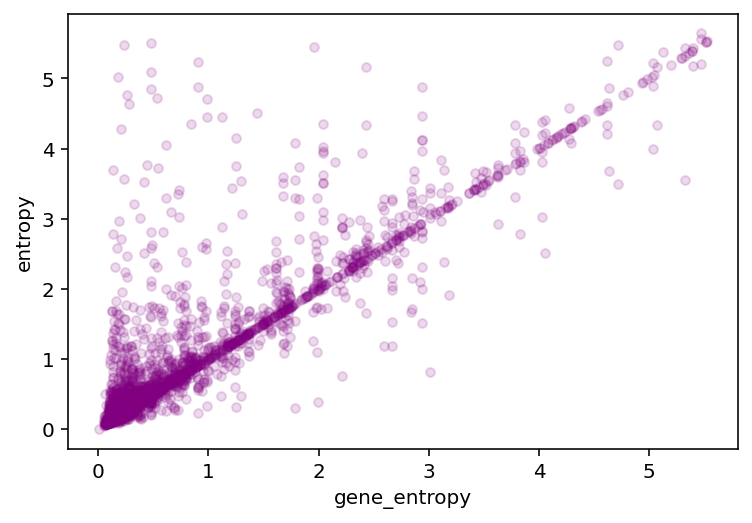

In [187]:
fig, ax = plt.subplots(1, 1)
(iso.loc[iso['max_TPM'] > 1, :]
    .plot.scatter(x='gene_entropy',
                  y='entropy',
                  alpha=0.15,
                  color='purple',
                  ax=ax))

In [155]:
# entropy per gene per tissue
entropy_per_tissue = pd.DataFrame(data=[means[c].groupby(genes).apply(stats.entropy) for c in means.columns]).T

/Users/lukelambourne/Work/tf_isoforms/venv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [178]:
genes.value_counts()[entropy_per_tissue.index]

ADNP      3
ADNP2     1
AEBP1     2
AEBP2     4
AHCTF1    3
         ..
ZSCAN9    4
ZUP1      2
ZXDA      1
ZXDB      1
ZXDC      2
Length: 1615, dtype: int64

Text(0, 0.5, 'Entropy per TF gene')

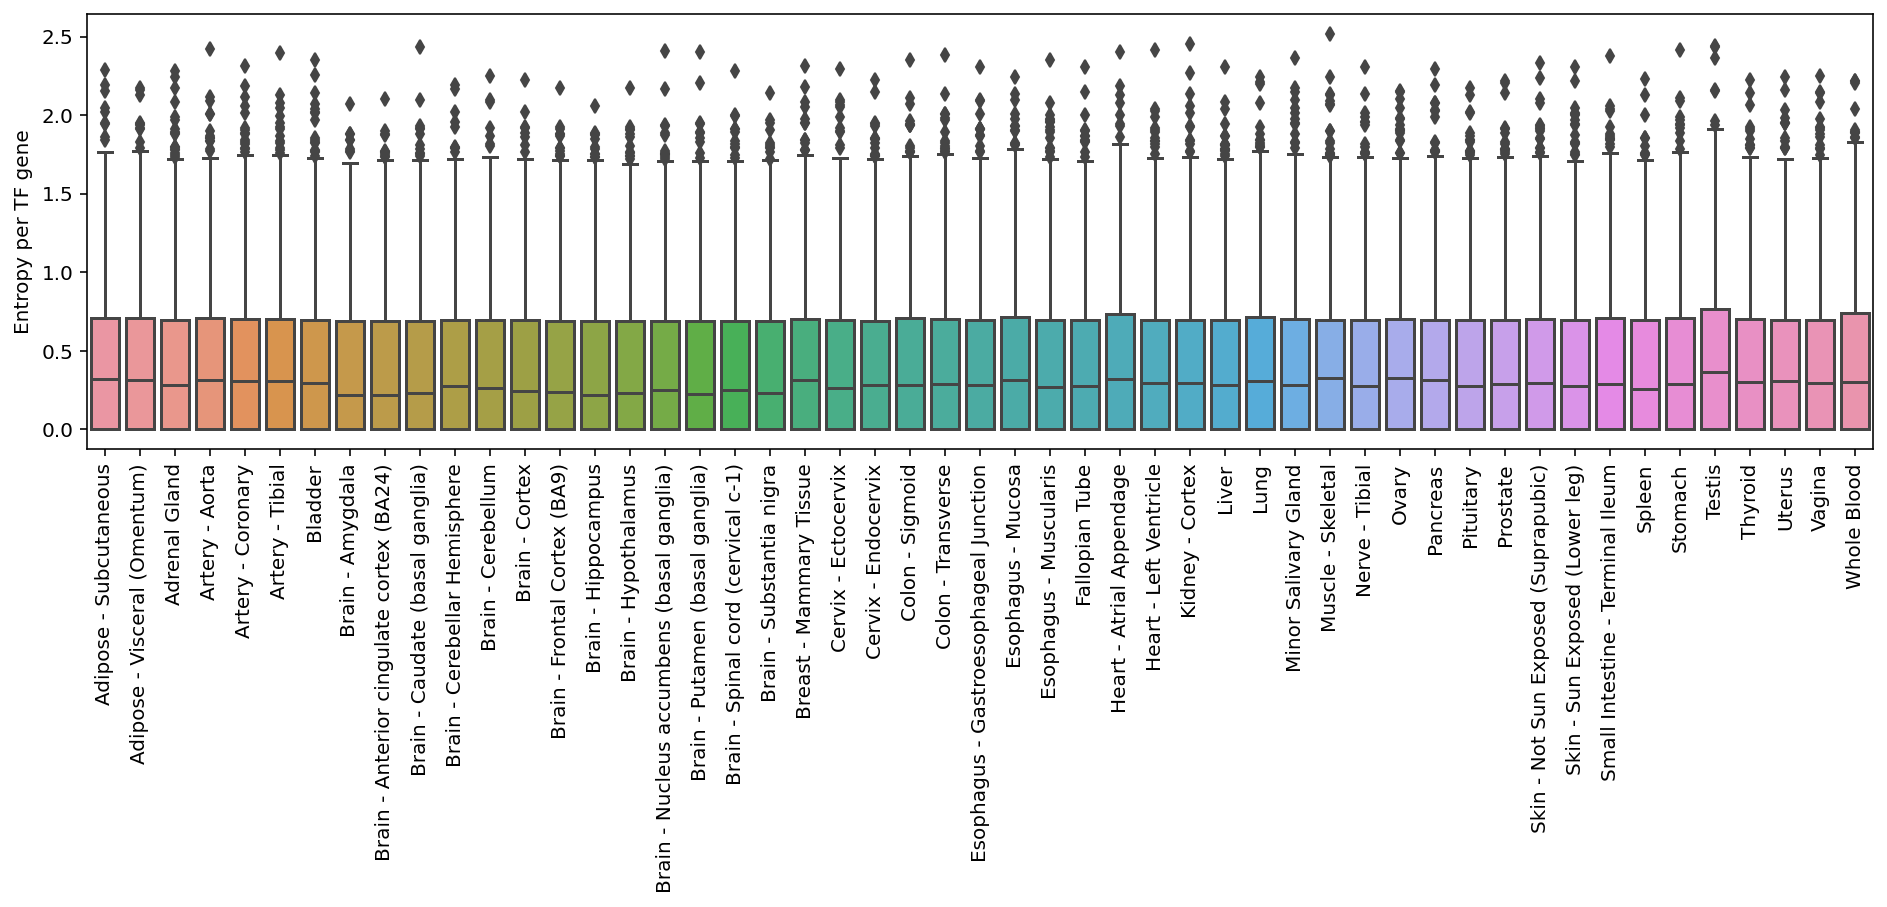

In [185]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 4)
sns.boxplot(data=entropy_per_tissue,
            ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Entropy per TF gene')

In [173]:
entropy_per_tissue.idxmax()

Adipose - Subcutaneous                         CREM
Adipose - Visceral (Omentum)                  FOXP2
Adrenal Gland                                  CREM
Artery - Aorta                                 CREM
Artery - Coronary                              CREM
Artery - Tibial                                CREM
Bladder                                        CREM
Brain - Amygdala                               CREM
Brain - Anterior cingulate cortex (BA24)       CREM
Brain - Caudate (basal ganglia)               NR1I3
Brain - Cerebellar Hemisphere                NFATC4
Brain - Cerebellum                             CREM
Brain - Cortex                                 CREM
Brain - Frontal Cortex (BA9)                   CREM
Brain - Hippocampus                            CREM
Brain - Hypothalamus                           CREM
Brain - Nucleus accumbens (basal ganglia)     NR1I3
Brain - Putamen (basal ganglia)               NR1I3
Brain - Spinal cord (cervical c-1)             CREM
Brain - Subs

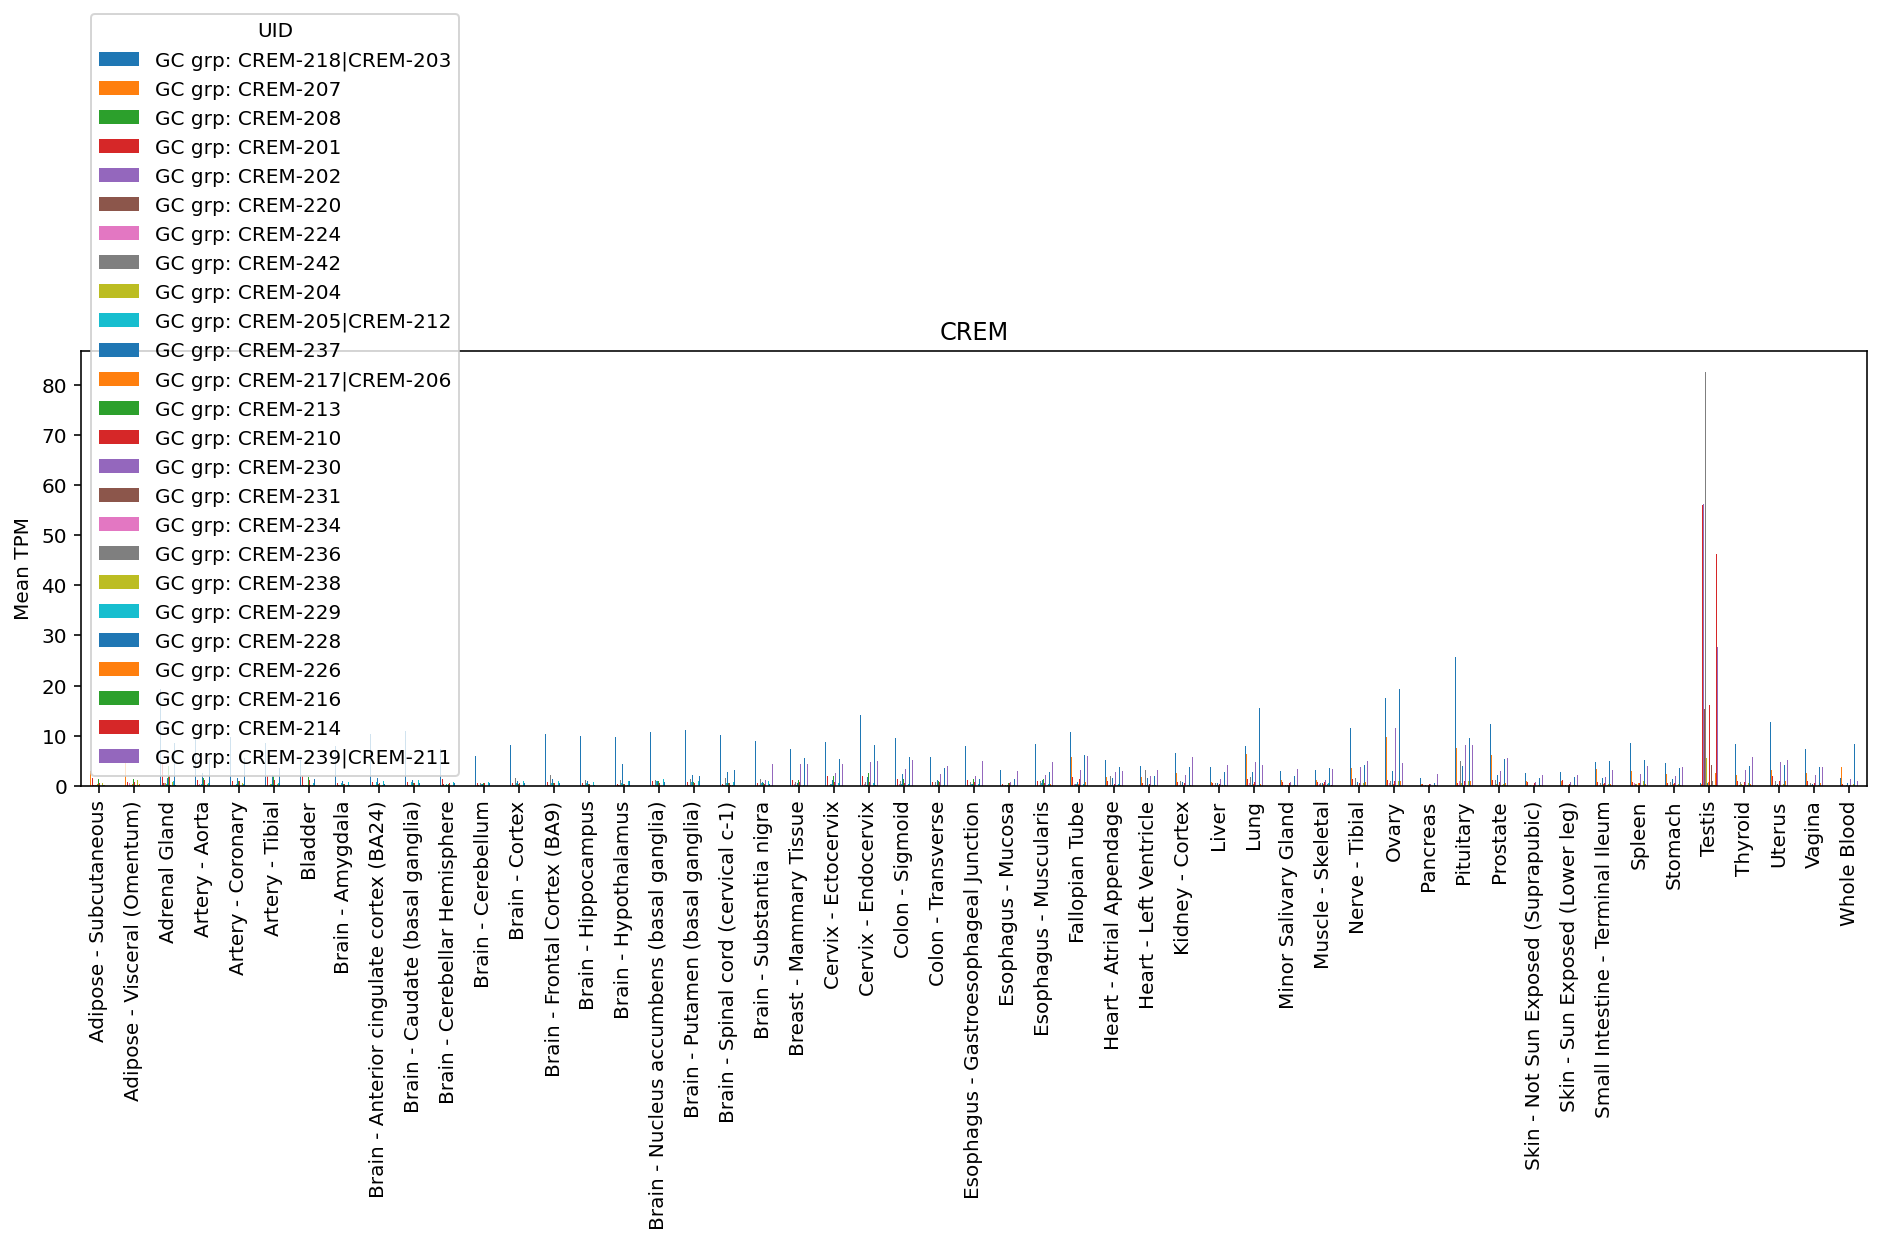

In [174]:
per_tf_gene_tissue_expression_plot('CREM')

(SpearmanrResult(correlation=0.9403074158789912, pvalue=0.0),
 (0.7936324180283093, 0.0))

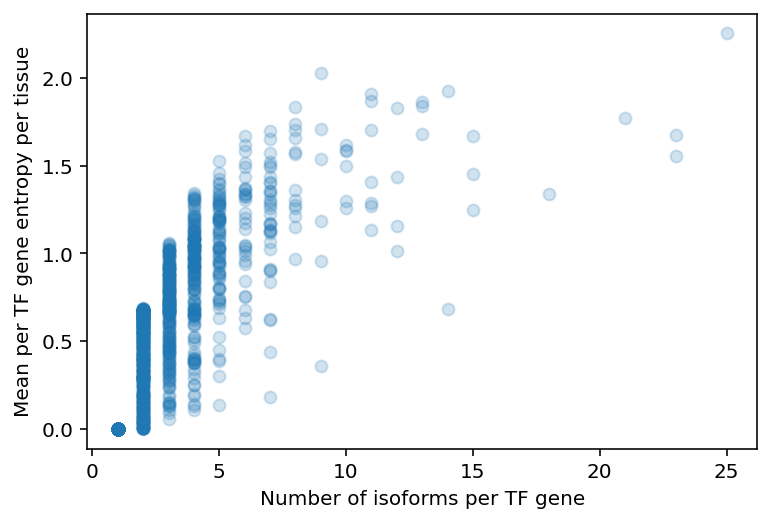

In [184]:
# looks like the entropy per tissue is mainly measuring the number of isoforms
fig, ax = plt.subplots(1, 1)
x = genes.value_counts()[entropy_per_tissue.index].values
y = entropy_per_tissue.mean(axis=1).values
ax.scatter(x, y, alpha=0.2)
ax.set_xlabel('Number of isoforms per TF gene')
ax.set_ylabel('Mean per TF gene entropy per tissue')
(stats.spearmanr(x, y), stats.pearsonr(x, y))

,mean_TPM,median_TPM,max_TPM,max_TiP_score,tissue_with_max_TiP_score,entropy,gene_max_TiP_score,gene_entropy,TiP_diff
UID,,,,,,,,,
GC grp: ATF2-203|ATF2-201,6.94,6.41,17.02,2.05,Brain - Cerebellar Hemisphere,0.16,2.73,0.14,-0.67
GC grp: ATF2-212,0.09,0.00,0.24,2.50,Brain - Cerebellum,0.31,2.73,0.14,-0.23
GC grp: ATF2-221,0.21,0.00,7.69,102.90,Testis,3.70,2.73,0.14,100.17
GC grp: ATF2-204,1.61,0.54,6.73,3.21,Brain - Cerebellar Hemisphere,0.48,2.73,0.14,0.49
GC grp: ATF2-202|ATF2-206,4.81,4.35,9.12,1.57,Cervix - Endocervix,0.13,2.73,0.14,-1.15
GC grp: ATF2-207,0.09,0.00,0.38,2.87,Cervix - Endocervix,0.60,2.73,0.14,0.14
GC grp: ATF2-205,0.89,0.65,4.04,3.04,Testis,0.60,2.73,0.14,0.31


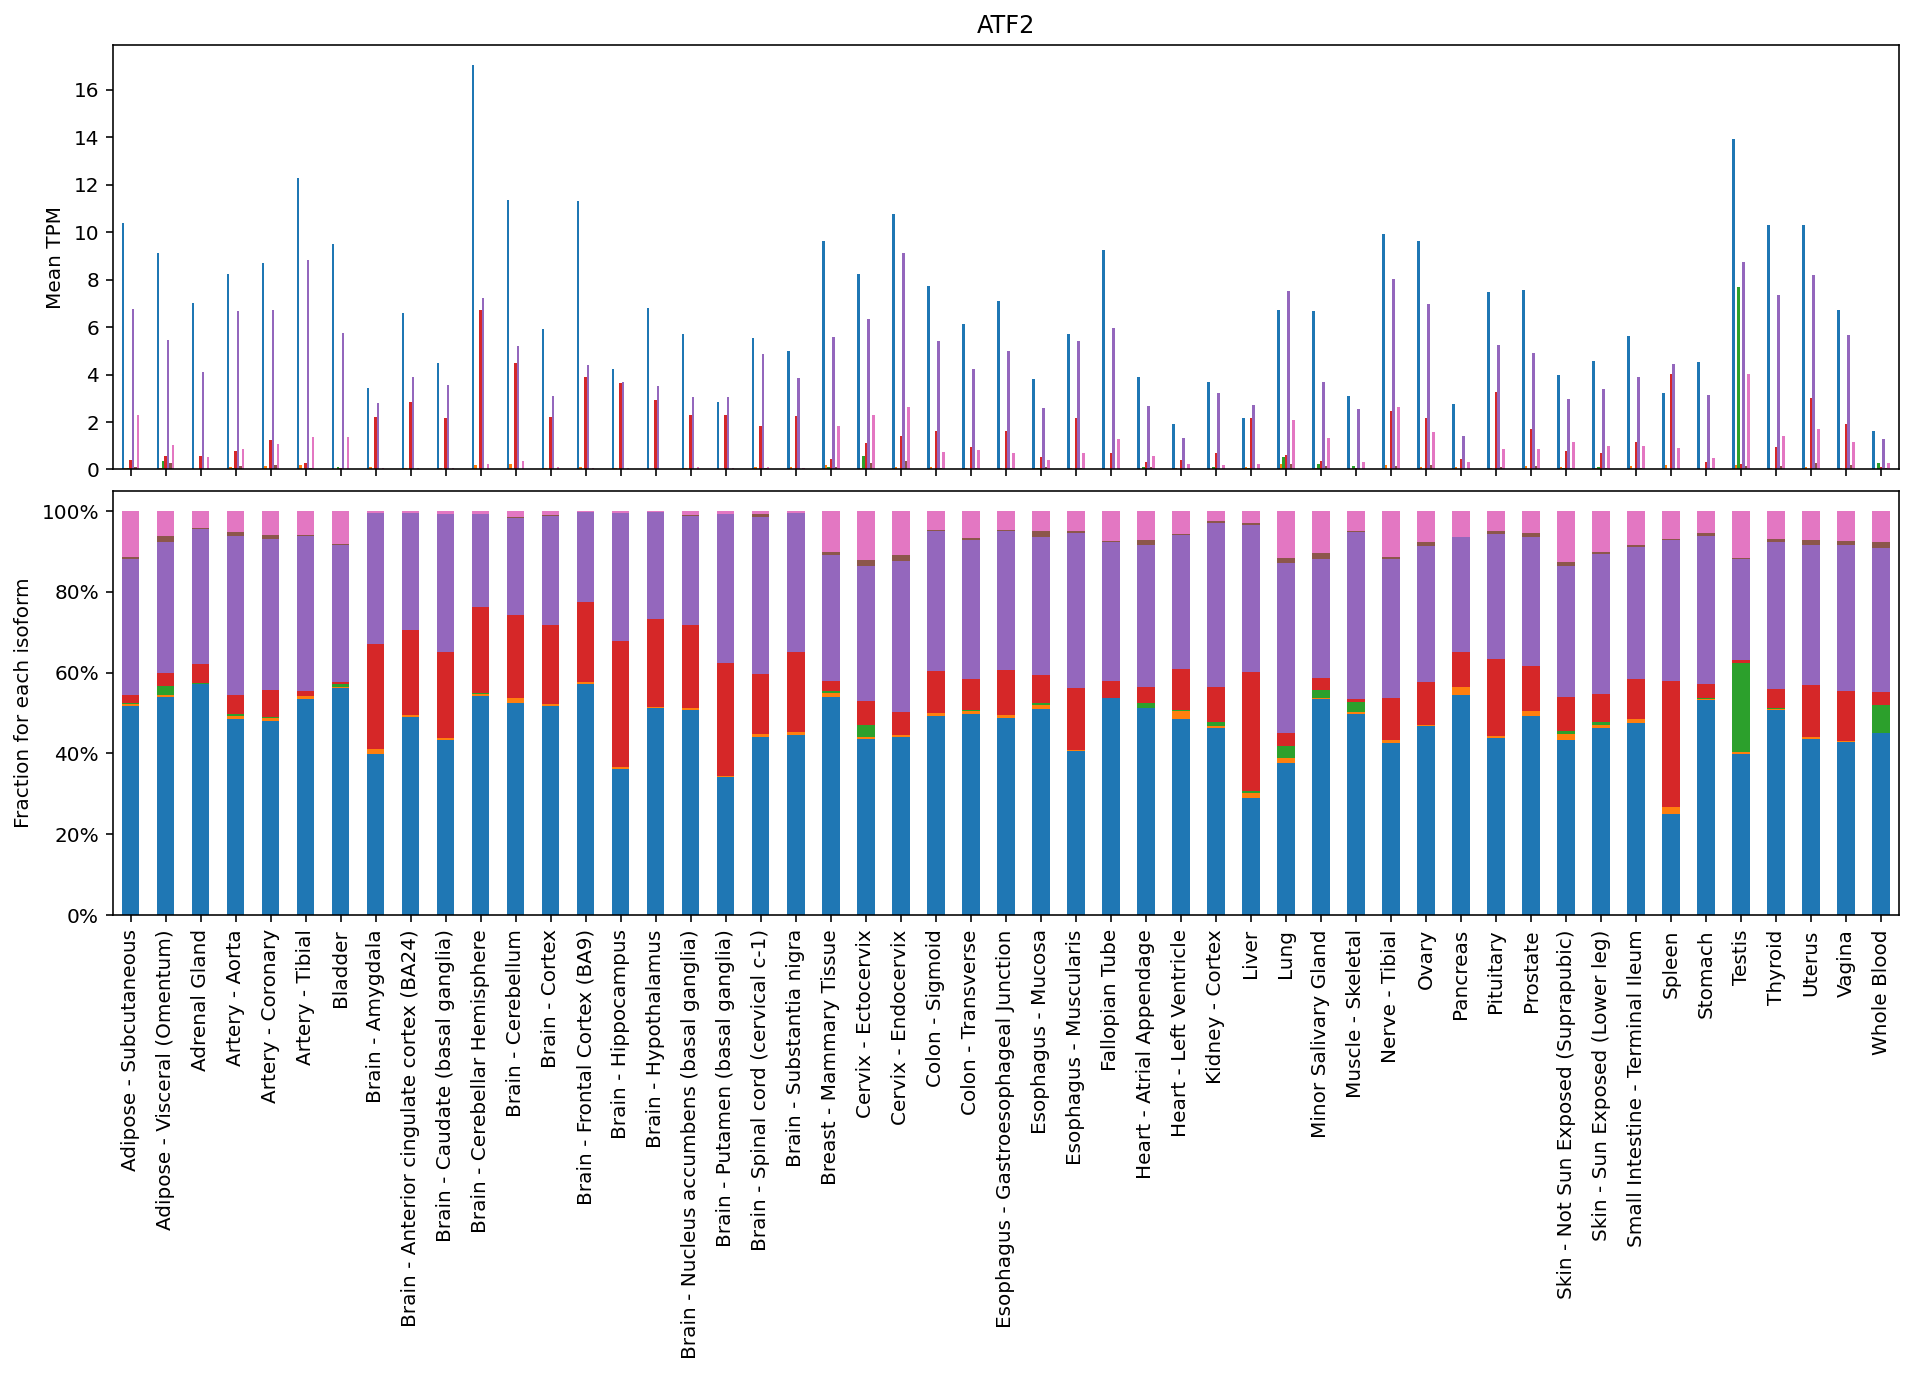

In [264]:
def table_and_graphs(gene_name):
    per_tf_gene_tissue_expression_plot(gene_name, draw_legend=False)
    table = iso.loc[iso['gene'] == gene_name,
                    filter(lambda x: x != 'gene', iso.columns)]
    return (table.style.set_precision(2)
             .apply(lambda x: pd.Series(index=table.index,
                                        data=['background-color: rgba({}, {}, {}, 0.4)'
                                              .format(*(x * 255 for x in matplotlib.colors.to_rgb('C' + str(i)))) 
                                              for i in range(table.shape[0])])))

table_and_graphs('ATF2')

,mean_TPM,median_TPM,max_TPM,max_TiP_score,tissue_with_max_TiP_score,entropy,gene_max_TiP_score,gene_entropy,TiP_diff
UID,,,,,,,,,
GC grp: CREM-218|CREM-203,8.37,7.34,25.81,3.62,Pituitary,0.21,19.38,0.48,-15.77
GC grp: CREM-207,2.89,1.65,9.76,3.33,Ovary,0.32,19.38,0.48,-16.06
GC grp: CREM-208,0.24,0.00,11.13,474.10,Testis,4.84,19.38,0.48,454.72
GC grp: CREM-201,2.13,0.79,55.93,93.59,Testis,2.04,19.38,0.48,74.21
GC grp: CREM-202,1.16,0.00,56.14,1359.55,Testis,5.10,19.38,0.48,1340.16
GC grp: CREM-220,0.46,0.00,15.25,104.19,Testis,2.81,19.38,0.48,84.80
GC grp: CREM-224,0.24,0.00,0.95,6.15,Pituitary,0.33,19.38,0.48,-13.24
GC grp: CREM-242,2.70,0.71,82.57,91.75,Testis,2.59,19.38,0.48,72.37
GC grp: CREM-204,0.33,0.18,5.66,45.76,Testis,1.16,19.38,0.48,26.38


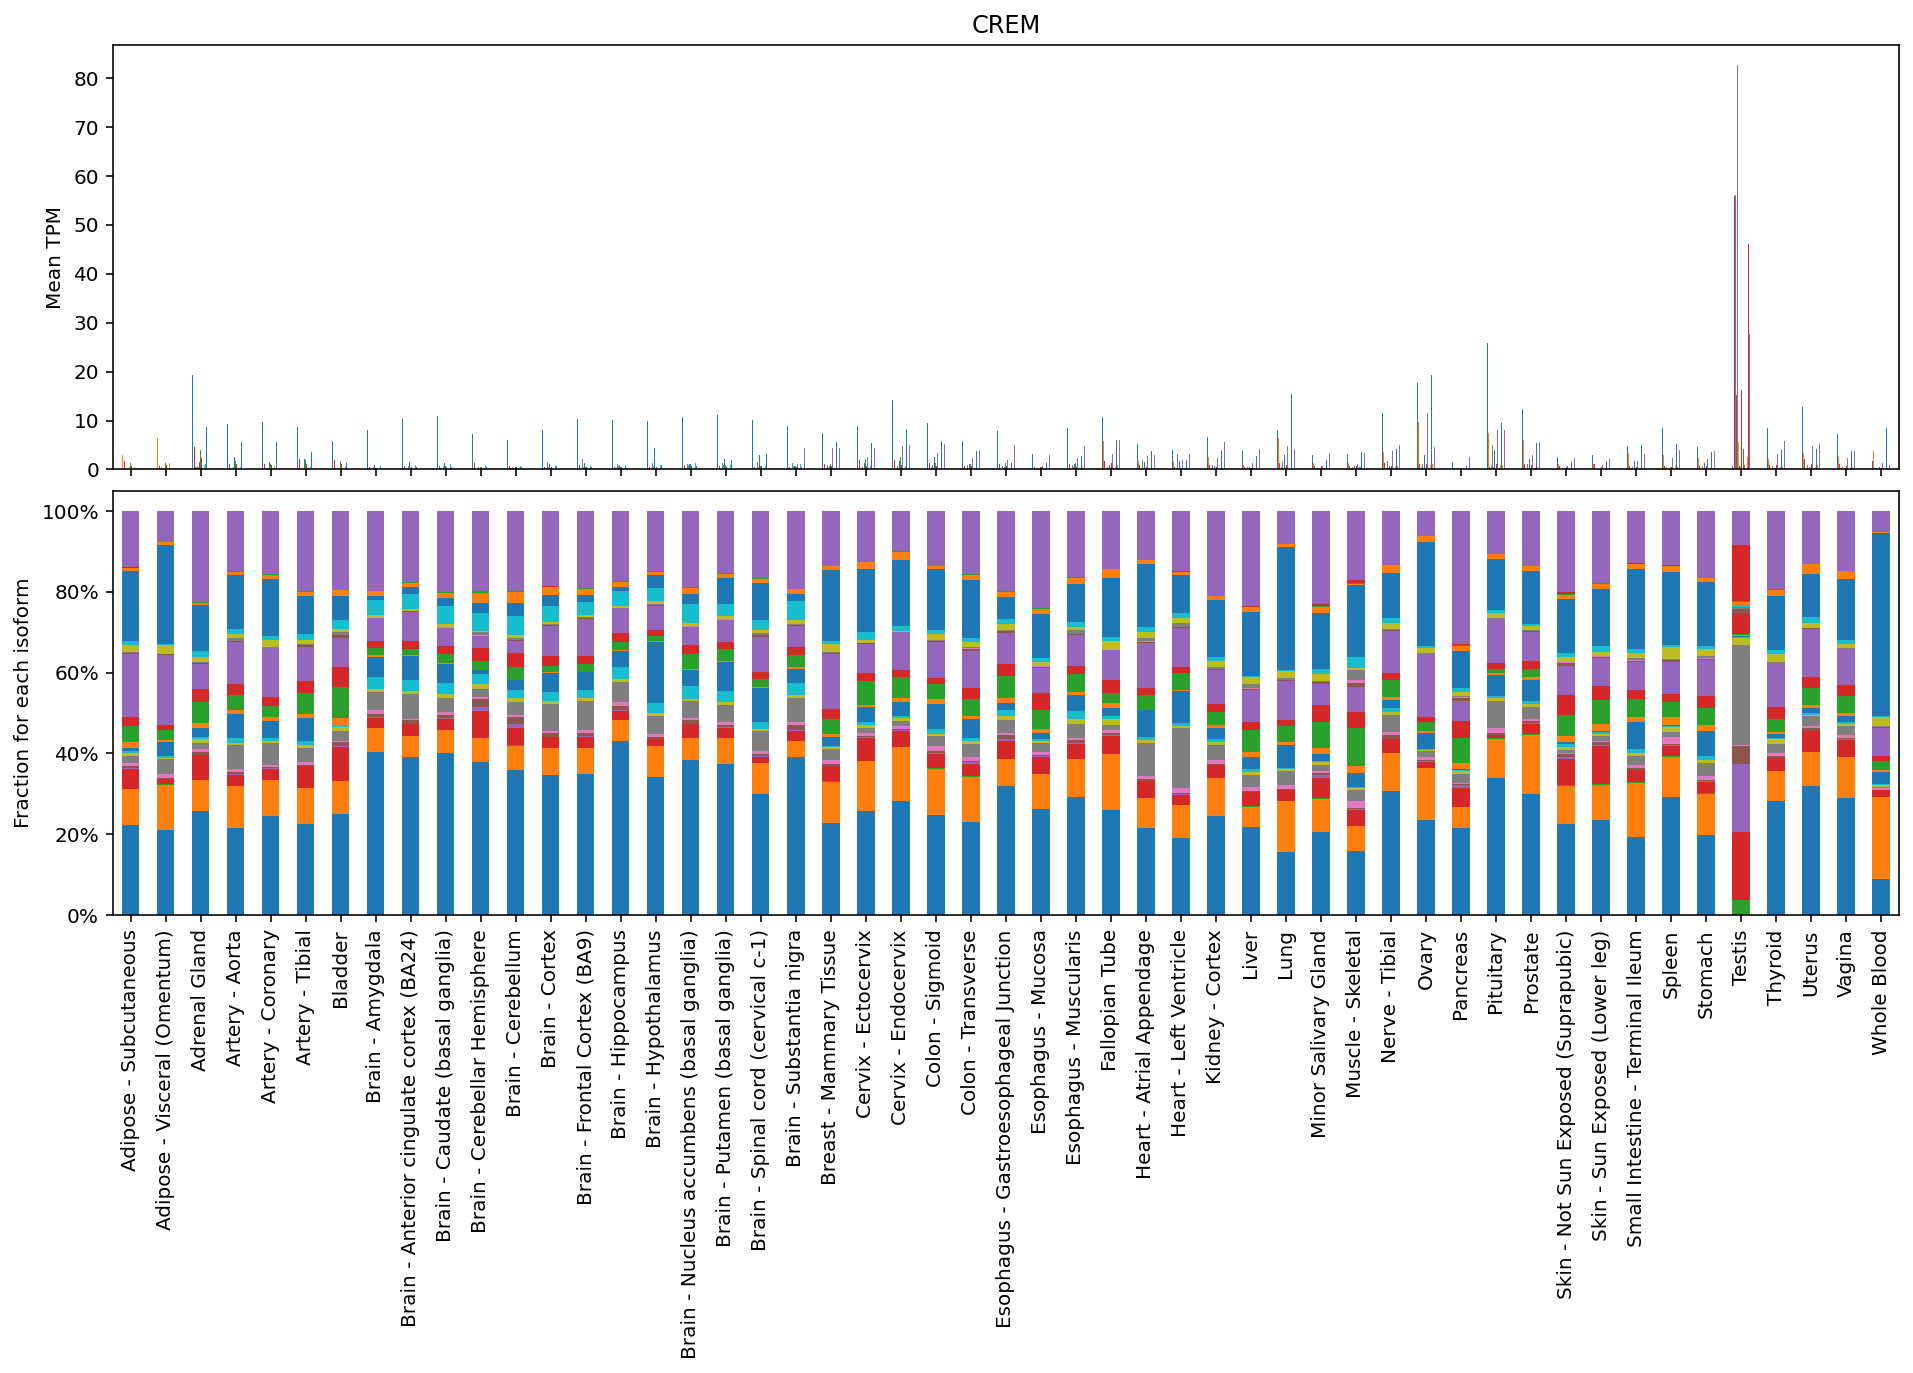

In [265]:
table_and_graphs('CREM')

,mean_TPM,median_TPM,max_TPM,max_TiP_score,tissue_with_max_TiP_score,entropy,gene_max_TiP_score,gene_entropy,TiP_diff
UID,,,,,,,,,
GC grp: FOXP2-203,0.02,0.00,0.08,2.35,Uterus,0.44,5.50,0.51,-3.15
GC grp: FOXP2-204,0.03,0.00,0.24,5.28,Cervix - Endocervix,1.12,5.50,0.51,-0.23
GC grp: FOXP2-207|FOXP2-201,0.54,0.16,4.82,11.76,Colon - Sigmoid,1.09,5.50,0.51,6.25
GC grp: FOXP2-210,0.80,0.28,3.63,3.54,Colon - Sigmoid,0.73,5.50,0.51,-1.96
GC grp: FOXP2-217,0.18,0.11,0.85,3.79,Colon - Sigmoid,0.48,5.50,0.51,-1.72
GC grp: FOXP2-209,0.03,0.00,0.52,25.88,Testis,1.47,5.50,0.51,20.38
GC grp: FOXP2-202,0.09,0.00,0.47,3.22,Uterus,0.76,5.50,0.51,-2.28
GC grp: FOXP2-206,0.63,0.31,3.76,5.69,Colon - Sigmoid,0.63,5.50,0.51,0.19
GC grp: FOXP2-205,0.13,0.06,0.73,4.10,Colon - Sigmoid,0.79,5.50,0.51,-1.41


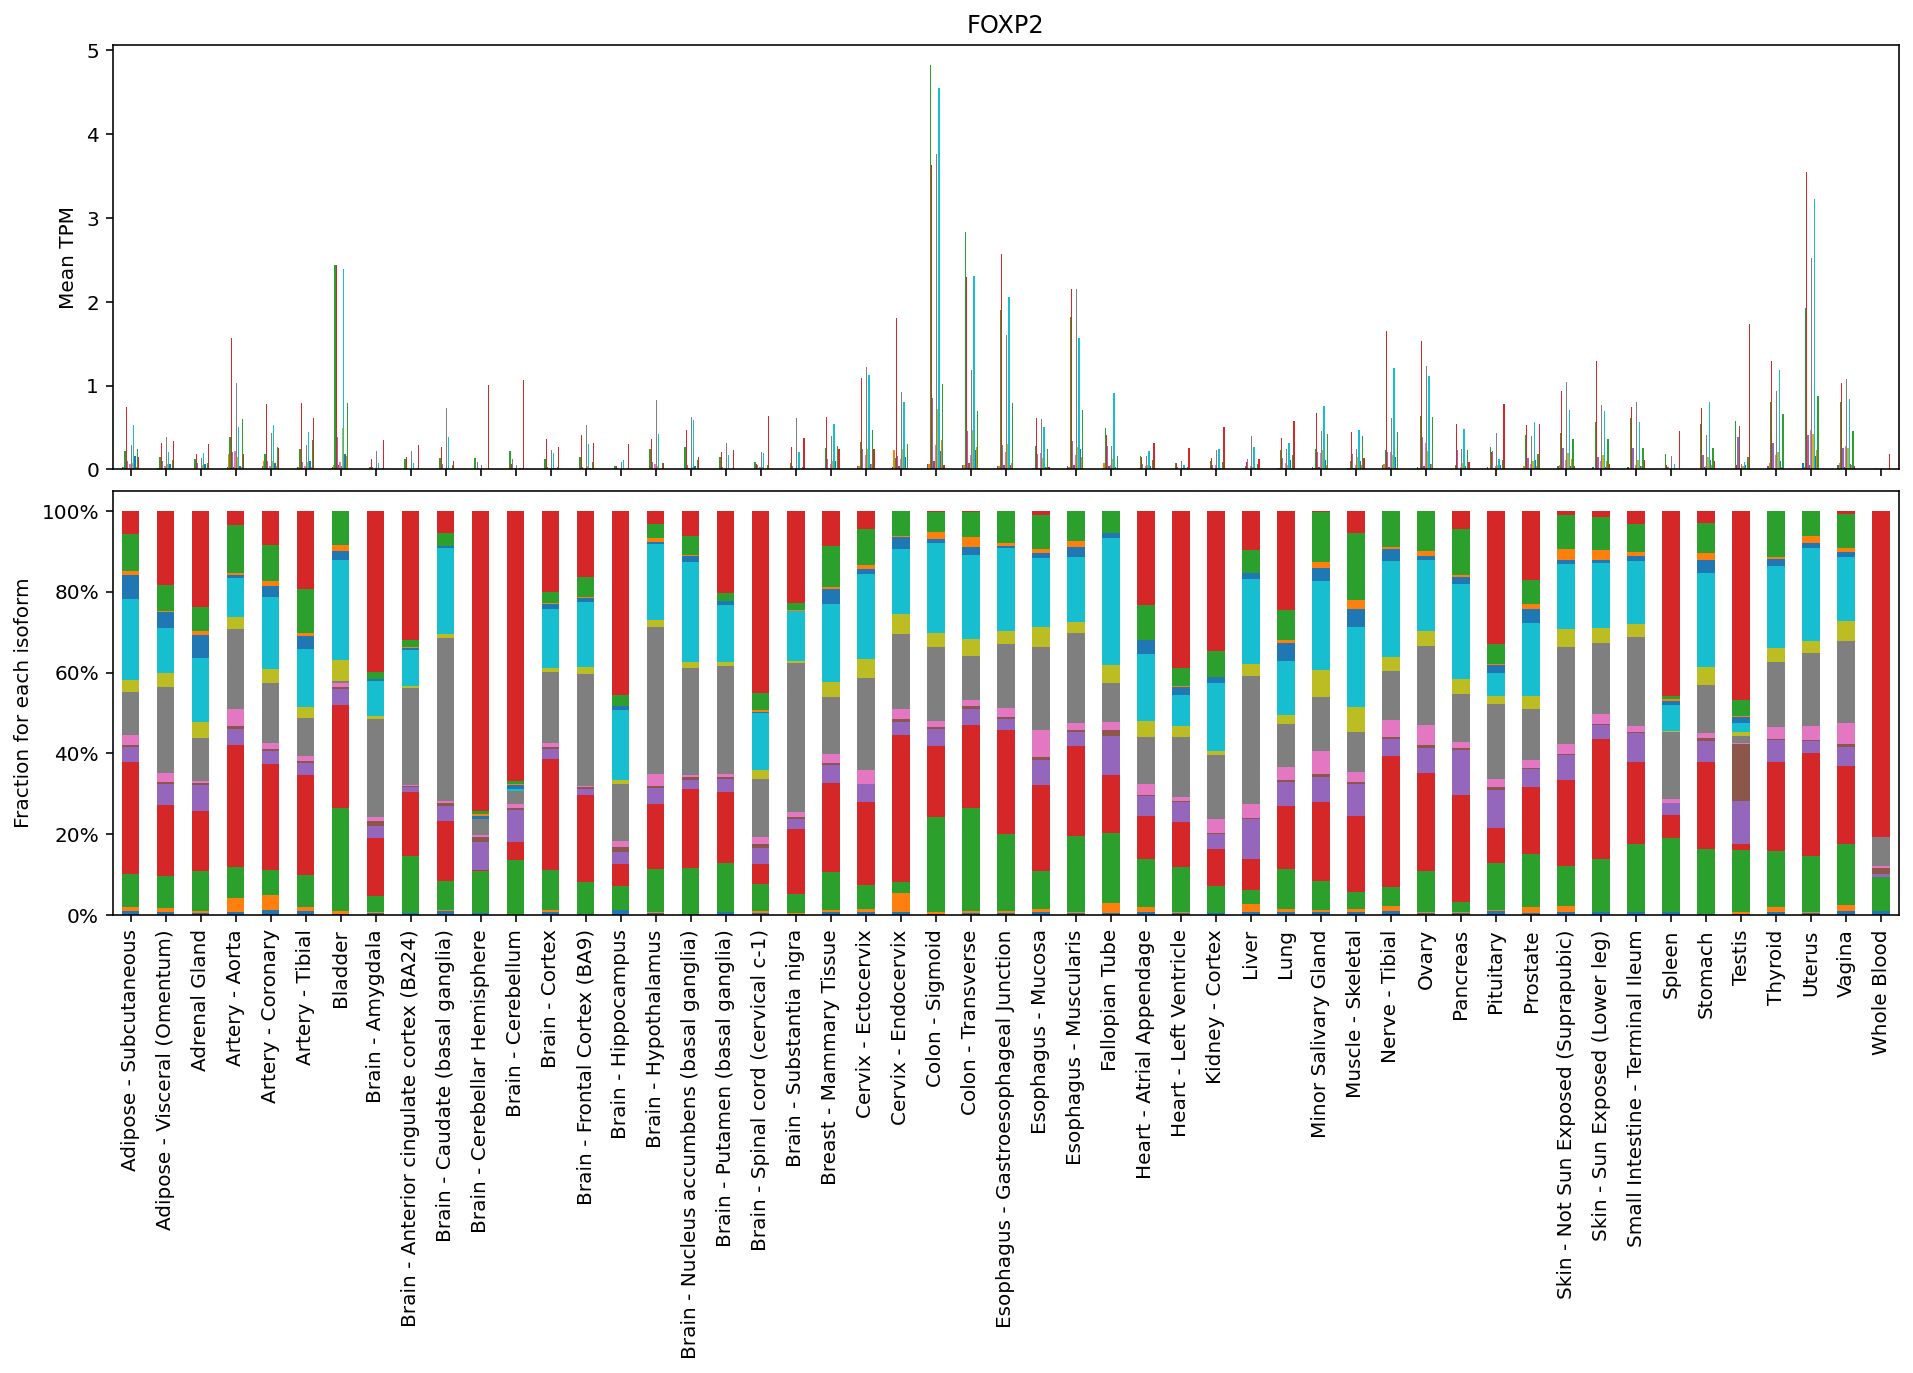

In [266]:
table_and_graphs('FOXP2')